In [ ]:
from google.colab import drive
#drive.flush_and_unmount
drive.mount('/gdrive',force_remount=True)

Mounted at /gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip uninstall scipy

In [ ]:
pip install scipy==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.2 MB 1.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.1.0 which is incompatible.
plotnine 0.8.0 requires scipy>=1.5.0, but you have scipy 1.1.0 which is incompatible.
jaxlib 0.3.14+cuda11.cudnn805 requires scipy>=1.5, but you have scipy 1.1.0 which is incompatible.
jax 0.3.14 requires scipy>=1.5, but you have scipy 1.1.0 which is incompatible.


In [ ]:
pip install nltk==3.4.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 32.0 MB/s 
  Created wheel for nltk: filename=nltk-3.4.5-py3-none-any.whl size=1449922 sha256=d1feb6c1552ebb3296914e65bb4a8bdcccb731c0913ffee730bd14898404db9c
  Stored in directory: /root/.cache/pip/wheels/48/8b/7f/473521e0c731c6566d631b281f323842bbda9bd819eb9a3ead
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7


In [ ]:
# utils.py
import os
import numpy as np
import h5py
import json
import torch
from scipy.misc import imread, imresize
from tqdm import tqdm
from collections import Counter
from random import seed, choice, sample
from sklearn.model_selection import train_test_split


def create_input_files(dataset, captions_per_image, min_word_freq, output_folder,data_tag):
    """
    Creates input files for training, validation, and test data.
    :param dataset: name of dataset, one of 'MSCOCO', 'DOGS'
    :param karpathy_json_path: path of Karpathy JSON file with splits and captions
    :param image_folder: folder with downloaded images
    :param captions_per_image: number of captions to sample per image
    :param min_word_freq: words occuring less frequently than this threshold are binned as <unk>s
    :param output_folder: folder to save files
    :param max_len: don't sample captions longer than this length
    """

    assert dataset in {'MSCOCO', 'DOGS'}
    
    '''   
    # Read Karpathy JSON
    with open(karpathy_json_path, 'r') as j:
        data = json.load(j)'''

    # Read image paths and captions for each image # KA : Populate these lists by importing pickles from TF notebook
    train_image_paths = []
    train_image_captions = []
    val_image_paths = []
    val_image_captions = []
    test_image_paths = []
    test_image_captions = []
    
    
    # MSCOCO : already shuffled in Pre-Processing Notebook and <start>,<end> already marked 
    import pickle
    
    #******************************************** DOGS: 5 captions per image

    # Read the text file
    def readfile(filename):
      file = open(filename, 'r')
      text = file.read()
      file.close()
      return text
    
    DOGS_image_captions=[]
    dog_desc_file= '/content/drive/MyDrive/DL_Project/dogs/KA_dogs.urd.descriptionsManual29Feb20.txt' ## UPDATE Filename HERE to Switch to better Captions
    text=readfile(dog_desc_file)
    for line in text.split('\n'):
      # split line by white space
      tokens = line.split()
      if len(line) < 2: # This is to escape the error in case of blank lines or last empty line.
        continue
      # make a list of all Dog Captions, where each caption is list of the constituting words
      DOGS_image_captions.append(tokens[1:])

    print("DOGS Captions:",len(DOGS_image_captions))
    print("DOGS sample:",DOGS_image_captions[:5])

    #****************Identify MAX_LEN & create a Word vs. Frequency dict 
    # MSCOCO_image_captions.copy() use when experimenting MSCOCO dataset on english
    overall_captions=[]
    overall_captions.extend(DOGS_image_captions)
    cap_lens=[len(c) for c in overall_captions]
    max_len = np.percentile(cap_lens,99) + 9
    max_len = int(max_len) # convert the value from float to int type i.e. 30.0 to 30
    print("max_len (after adding 9):",max_len)
    
    word_freq = Counter() # Counter provides a container i.e. a dictionary computed on an input list such that elements of list=keys, elemnt counts=value 
    for c in overall_captions:
        # Update word frequency
        word_freq.update(c)  # i.e. update the counts of existing words or add new words with counts to the word_freq dict

    #****************
    if dataset=='DOGS':
      # Construct Train,Validation,Test PathedImageName lists for Dogs reading from txt files provided from Keras Captions Notebook
      def returnImageNameList(filename):
        ImageNameList=[]
        text=readfile(filename)
        for imgid in text.split('\n'):
          if len(imgid) < 4: # This is to escape the error in case of blank lines or last empty line.
            continue
          if os.path.isfile('/content/drive/MyDrive/DL_Project/Flickr8k_data/Flicker8k_Dataset/'+imgid): # i.e. make an ImageId part of list only if relevant image file exists on filesystem
            ImageNameList.append('/content/drive/MyDrive/DL_Project/Flickr8k_data/Flicker8k_Dataset/'+imgid) # i.e. exclude the .jpg from image name for matching that is eventually to be done
        return ImageNameList

      train_image_L= returnImageNameList('/content/drive/MyDrive/DL_Project/type_a/experiment/train.txt')
      val_image_L=   returnImageNameList('/content/drive/MyDrive/DL_Project/type_a/experiment/val.txt')
      test_image_L=   returnImageNameList('/content/drive/MyDrive/DL_Project/type_a/experiment/test.txt')
      print(train_image_L)
      previous_img_id=''
      AllCapsOfImage=[]
      text=readfile(dog_desc_file)
      print(text[:50])
      for line in text.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2: # This is to escape the error in case of blank lines or last empty line.
          continue
        
        image_id, image_desc = tokens[0], tokens[1:] # split imageId and caption 
        image_id='/content/drive/MyDrive/DL_Project/Flickr8k_data/Flicker8k_Dataset/'+image_id+'.jpg'
        if previous_img_id=='':
          previous_img_id=image_id
        if previous_img_id==image_id:
          if len(image_desc) <= max_len:
            AllCapsOfImage.append(image_desc)
          else:
            AllCapsOfImage.append(image_desc[:max_len])
        else:
          if previous_img_id in train_image_L:
            train_image_paths.append(previous_img_id)
            train_image_captions.append(AllCapsOfImage)
          elif previous_img_id in val_image_L:
            val_image_paths.append(previous_img_id)
            val_image_captions.append(AllCapsOfImage)
          elif previous_img_id in test_image_L:
            test_image_paths.append(previous_img_id)
            test_image_captions.append(AllCapsOfImage)
          AllCapsOfImage=[]
          previous_img_id=image_id
          if len(image_desc) <= max_len:
            AllCapsOfImage.append(image_desc)
          else:
            AllCapsOfImage.append(image_desc[:max_len])


      print("DOGS (image_paths,captions) :: train:",(len(train_image_paths),len(train_image_captions)), "valid:",(len(val_image_paths),len(val_image_captions)), "test:",(len(test_image_paths),len(test_image_captions)) )
      print("DOGS train sample:",train_image_captions[:5])

    # Sanity check
    assert len(train_image_paths) == len(train_image_captions)
    assert len(val_image_paths) == len(val_image_captions)
    assert len(test_image_paths) == len(test_image_captions)

    # Create word map
    words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq] # Filter the words that are less frequent than minimum
    word_map = {k: v + 4 for v, k in enumerate(words)} # Create word_map i.e. dict with key=word, value=int incremental where <pad><start><end><unk>: 0-3
    word_map['<unk>'] = 3   #len(word_map) + 1
    word_map['<end>'] = 2   #len(word_map) + 1
    word_map['<start>'] = 1 #len(word_map) + 1
    word_map['<pad>'] = 0
    print("Vocab. Size:", len(word_map))

    # Create a base/root name for all output files
    base_filename = data_tag + dataset + '_' + str(captions_per_image) + '_cap_per_img_' + str(min_word_freq) + '_min_word_freq'
    # Save word map to a JSON
    with open(os.path.join(output_folder, 'WORDMAP_' + base_filename + '.json'), 'w') as j:
        json.dump(word_map, j)

    # Sample captions for each image, save images to HDF5 file, and captions and their lengths to JSON files
    seed(1)
    for impaths, imcaps, split in [(train_image_paths, train_image_captions, 'TRAIN'),
                                   (val_image_paths, val_image_captions, 'VAL'),
                                   (test_image_paths, test_image_captions, 'TEST')]:
        print(os.path.join(output_folder, split + '_IMAGES_' + base_filename + '.hdf5'))
        with h5py.File(os.path.join(output_folder, split + '_IMAGES_' + base_filename + '.hdf5'), 'a') as h:
            # Make a note of the number of captions we are sampling per image
            h.attrs['captions_per_image'] = captions_per_image

            # Create dataset inside HDF5 file to store images
            images = h.create_dataset('images', (len(impaths), 3, 256, 256), dtype='uint8')

            print("\nReading %s images and captions, storing to file...\n" % split)

            enc_captions = []
            caplens = []

            for i, path in enumerate(tqdm(impaths)):

                # Sample captions
                if len(imcaps[i]) < captions_per_image:
                    captions = imcaps[i] + [choice(imcaps[i]) for _ in range(captions_per_image - len(imcaps[i]))]
                else:
                    captions = sample(imcaps[i], k=captions_per_image)

                # Sanity check
                assert len(captions) == captions_per_image

                # Read images
                img = imread(impaths[i])
                if len(img.shape) == 2:
                    img = img[:, :, np.newaxis]
                    img = np.concatenate([img, img, img], axis=2)
                img = imresize(img, (256, 256))
                img = img.transpose(2, 0, 1)
                assert img.shape == (3, 256, 256)
                assert np.max(img) <= 255

                # Save image to HDF5 file
                images[i] = img

                for j, c in enumerate(captions):
                    # Encode captions using word_map by appending <start>,<end> then <pad> at the end to make all captions max_len sized
                    enc_c = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in c] + [
                        word_map['<end>']] + [word_map['<pad>']] * (max_len - len(c))

                    # Find caption lengths
                    c_len = len(c) + 2

                    enc_captions.append(enc_c)
                    caplens.append(c_len)

            # Sanity check
            assert images.shape[0] * captions_per_image == len(enc_captions) == len(caplens)

            # Save encoded captions and their lengths to JSON files
            with open(os.path.join(output_folder, split + '_CAPTIONS_' + base_filename + '.json'), 'w') as j:
                json.dump(enc_captions, j)

            with open(os.path.join(output_folder, split + '_CAPLENS_' + base_filename + '.json'), 'w') as j:
                json.dump(caplens, j)
    return max_len


def init_embedding(embeddings):
    """
    Fills embedding tensor with values from the uniform distribution.
    :param embeddings: embedding tensor
    """
    bias = np.sqrt(3.0 / embeddings.size(1))
    torch.nn.init.uniform_(embeddings, -bias, bias)


def load_embeddings(emb_file, word_map):
    """
    Creates an embedding tensor for the specified word map, for loading into the model.
    :param emb_file: file containing embeddings (stored in GloVe format)
    :param word_map: word map
    :return: embeddings in the same order as the words in the word map, dimension of embeddings
    """

    # Find embedding dimension
    with open(emb_file, 'r') as f:
        emb_dim = len(f.readline().split(' ')) - 1

    vocab = set(word_map.keys())

    # Create tensor to hold embeddings, initialize
    embeddings = torch.FloatTensor(len(vocab), emb_dim)
    init_embedding(embeddings)

    # Read embedding file
    print("\nLoading embeddings...")
    for line in open(emb_file, 'r'):
        line = line.split(' ')

        emb_word = line[0]
        embedding = list(map(lambda t: float(t), filter(lambda n: n and not n.isspace(), line[1:])))

        # Ignore word if not in train_vocab
        if emb_word not in vocab:
            continue

        embeddings[word_map[emb_word]] = torch.FloatTensor(embedding)

    return embeddings, emb_dim


def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.
    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)


def save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer, decoder_optimizer,
                    bleu4, is_best , ):
    """
    Saves model checkpoint.
    :param data_name: base name of processed dataset
    :param epoch: epoch number
    :param epochs_since_improvement: number of epochs since last improvement in BLEU-4 score
    :param encoder: encoder model
    :param decoder: decoder model
    :param encoder_optimizer: optimizer to update encoder's weights, if fine-tuning
    :param decoder_optimizer: optimizer to update decoder's weights
    :param bleu4: validation BLEU-4 score for this epoch
    :param is_best: is this checkpoint the best so far?
    """
    state = {'epoch': epoch,
             'epochs_since_improvement': epochs_since_improvement,
             'bleu-4': bleu4,
             'encoder': encoder,
             'decoder': decoder,
             'encoder_optimizer': encoder_optimizer,
             'decoder_optimizer': decoder_optimizer}
    filename = ModelType+'checkpoint_' + data_name + '.pth.tar'
    torch.save(state, '/content/checkpoints/'+filename)
    # If this checkpoint is the best so far, store a copy so it doesn't get overwritten by a worse checkpoint
    if is_best:
        torch.save(state, '/content/checkpoints/'+'BEST_' + filename)


class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(optimizer, shrink_factor):
    """
    Shrinks learning rate by a specified factor.
    :param optimizer: optimizer whose learning rate must be shrunk.
    :param shrink_factor: factor in interval (0, 1) to multiply learning rate with.
    """

    print("\nDECAYING learning rate.")
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]['lr'],))


def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.
    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    """

    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

In [ ]:
!ls -l -h '/gdrive/My Drive/Colab Notebooks/ImageCaptionThesis/PyTorch/'
# FinalData means the data files of latest captions 

ls: cannot access '/gdrive/My Drive/Colab Notebooks/ImageCaptionThesis/PyTorch/': Transport endpoint is not connected


In [ ]:
# Set path and dataNames here
data_tag='FinalData_'  #''  #data_tag is to switch the whole notebook to the use finalized image descriptions or use older datafiles.
data_folder = '/content/drive/MyDrive/DL_Project/ImageCaptionThesis/PyTorch'  # folder with data files saved by create_input_files.py
data_name = data_tag+'DOGS_5_cap_per_img_2_min_word_freq'   #'DOGS_5_cap_per_img_2_min_word_freq'  # BASE NAME shared by data files
word_map_file = os.path.join(data_folder, 'WORDMAP_' + data_name + '.json')
with open(word_map_file, 'r') as j:
    word_map = json.load(j)
    
    
rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

# Set Model Type to store and Load Checkpoint:
ModelType='FlipTransform'



In [ ]:
!pip install gensim==4.1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 66.4 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:

import gensim
# Train Word2Vec model with gensim on the dataset
w2v_model = gensim.models.Word2Vec.load('/content/drive/MyDrive/DL_Project/ImageCaptionThesis/wordvec/vector_size_512_window_10/genism_word2Vec_9000000.model')
print(w2v_model.wv.key_to_index)
def create_embedding(word_map, tokenize_level, load_from_file=True):
    if os.path.isfile('/content/embedding_matrix_pre_build_word.npy'):
        print('Load embedding matrix %s level pre build from file!' % tokenize_level)
        with open('/content/embedding_matrix_pre_build_word.npy', 'rb') as f:
            embedding_matrix = np.load(f)
    else:
        print('Build new embedding matrix and save to embedding_matrix_pre_build_%s.npy! \n ...' % tokenize_level)
        embeddings_index = {}
        embedding_dim = 512
        max_feature = 1000
        num_words = len(word_map)
        embedding_matrix = np.zeros((num_words, embedding_dim))
      
        

        for word, i in word_map.items():
            if i > max_feature:
                continue
            try:
              embedding_vector = w2v_model.wv.get_vector(word)
              if embedding_vector is not None:
                  embedding_matrix[i] = embedding_vector
              else:
                  embedding_matrix[i] = np.random.randn(embedding_dim)
            except:
                  embedding_matrix[i] = np.random.randn(embedding_dim)
    np.save('./embedding_matrix_pre_build_%s.npy' % tokenize_level, embedding_matrix) # save

    embedding_matrix = torch.from_numpy(embedding_matrix).float()
    embedding_matrix = embedding_matrix

    print("Word Embedding loaded!")

    return embedding_matrix
emb_mat=create_embedding(word_map,"word",load_from_file=True)
emb_mat.shape

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



torch.Size([1172, 512])

In [ ]:

#create_input_files.py
#from utils import create_input_files

if __name__ == '__main__':
    # Create input files (along with word map)
    create_input_files(dataset='DOGS',
                       captions_per_image=5,
                       min_word_freq=2,
                       output_folder=data_folder,
                       data_tag=data_tag
                       )


DOGS Captions: 8995
DOGS sample: [['ایک', 'سیاہ', 'کتا', 'اور', 'ایک', 'دھبوں', 'والا', 'کتا', 'لڑ', 'رہے', 'ہیں'], ['سڑک', 'پر', 'ایک', 'سیاہ', 'کتا', 'دوسرے', 'سفید', 'بھورے', 'دھبوں', 'والے', 'کتے', 'کے', 'ساتھ', 'کھیل', 'رہا', 'ہے'], ['ایک', 'سیاہ', 'کتا', 'اور', 'ایک', 'سفید', 'بھورے', 'دھبوں', 'والا', 'کتا', 'گلی', 'میں', 'ایک', 'دوسرے', 'کو', 'گھور', 'رہے', 'ہیں'], ['دو', 'مختلف', 'نسل', 'کے', 'کتے', 'سڑک', 'پر', 'ایک', 'دوسرے', 'کو', 'دیکھ', 'رہے', 'ہیں'], ['دو', 'کتے', 'فٹ', 'پاتھ', 'پر', 'ایک', 'دوسرے', 'کی', 'طرف', 'بڑھ', 'رہے', 'ہیں']]
max_len (after adding 9): 31
['/content/drive/MyDrive/DL_Project/Flickr8k_data/Flicker8k_Dataset/496555371_3e1ee0d97d.jpg', '/content/drive/MyDrive/DL_Project/Flickr8k_data/Flicker8k_Dataset/3455757720_7aeba57056.jpg', '/content/drive/MyDrive/DL_Project/Flickr8k_data/Flicker8k_Dataset/3519155763_045a6a55e2.jpg', '/content/drive/MyDrive/DL_Project/Flickr8k_data/Flicker8k_Dataset/2508313118_524e93d48c.jpg', '/content/drive/MyDrive/DL_Project/Fl

ValueError: ignored

In [ ]:
# datasets.py
import torch
from torch.utils.data import Dataset
import h5py
import json
import os

class CaptionDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """

    def __init__(self, data_folder, data_name, split, transform=None):
        """
        :param data_folder: folder where data files are stored
        :param data_name: base name of processed datasets
        :param split: split, one of 'TRAIN', 'VAL', or 'TEST'
        :param transform: image transform pipeline
        """
        self.split = split
        assert self.split in {'TRAIN', 'VAL', 'TEST'}

        # Open hdf5 file where images are stored
        self.h = h5py.File(os.path.join(data_folder, self.split + '_IMAGES_' + data_name + '.hdf5'), 'r')
        self.imgs = self.h['images']

        # Captions per image
        self.cpi = self.h.attrs['captions_per_image']

        # Load encoded captions (completely into memory)
        with open(os.path.join(data_folder, self.split + '_CAPTIONS_' + data_name + '.json'), 'r') as j:
            self.captions = json.load(j)

        # Load caption lengths (completely into memory)
        with open(os.path.join(data_folder, self.split + '_CAPLENS_' + data_name + '.json'), 'r') as j:
            self.caplens = json.load(j)

        # PyTorch transformation pipeline for the image (normalizing, etc.)
        self.transform = transform

        # Total number of datapoints
        self.dataset_size = len(self.captions)
#        ##Added by KA: to avoid over sampling the 180 eval images as 900 
#        if self.split in ['VAL']:
#          self.dataset_size = int(len(self.captions)/self.cpi)


    def __getitem__(self, i):
        # Remember, the Nth caption corresponds to the (N // captions_per_image)th image
        img = torch.FloatTensor(self.imgs[i // self.cpi] / 255.)
        if self.transform is not None:
            img = self.transform(img)

        caption = torch.LongTensor(self.captions[i])

        caplen = torch.LongTensor([self.caplens[i]])

        if self.split is 'TRAIN':
            return img, caption, caplen
#        ##Added by KA: to avoid over sampling the 180 eval images as 900 
#        elif self.split in ['VAL']:
#            # For validation, also return all 'captions_per_image' captions to find BLEU-4 score
#            all_captions = torch.LongTensor(
#                self.captions[((i) * self.cpi):(((i) * self.cpi) + self.cpi)])
#            return img, caption, caplen, all_captions'''
        else:
            # For validation of testing, also return all 'captions_per_image' captions to find BLEU-4 score
            all_captions = torch.LongTensor(
                self.captions[((i // self.cpi) * self.cpi):(((i // self.cpi) * self.cpi) + self.cpi)])
            return img, caption, caplen, all_captions

    def __len__(self):
        return self.dataset_size

In [ ]:
#models.py
import torch
from torch import nn
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Encoder(nn.Module):
    """
    Encoder.
    """

    def __init__(self, encoded_image_size=14):
        super(Encoder, self).__init__()
        self.enc_image_size = encoded_image_size

        resnet = torchvision.models.resnet101(pretrained=True)  # pretrained ImageNet ResNet-101

        # Remove linear and pool layers (since we're not doing classification)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # Resize image to fixed size to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

        self.fine_tune()

    def forward(self, images):
        """
        Forward propagation.
        :param images: images, a tensor of dimensions (batch_size, 3, image_size, image_size)
        :return: encoded images
        """
        out = self.resnet(images)  # (batch_size, 2048, image_size/32, image_size/32)
        out = self.adaptive_pool(out)  # (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = out.permute(0, 2, 3, 1)  # (batch_size, encoded_image_size, encoded_image_size, 2048)
        return out

    def fine_tune(self, fine_tune=True):
        """
        Allow or prevent the computation of gradients for convolutional blocks 2 through 4 of the encoder.
        :param fine_tune: Allow?
        """
        for p in self.resnet.parameters():
            p.requires_grad = False
        # If fine-tuning, only fine-tune convolutional blocks 2 through 4
        for c in list(self.resnet.children())[5:]:
            for p in c.parameters():
                p.requires_grad = fine_tune


class Attention(nn.Module):
    """
    Attention Network.
    """

    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: feature size of encoded images
        :param decoder_dim: size of decoder's RNN
        :param attention_dim: size of the attention network
        """
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dimension (batch_size, decoder_dim)
        :return: attention weighted encoding, weights
        """
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)

        return attention_weighted_encoding, alpha


class DecoderWithAttention(nn.Module):
    """
    Decoder.
    """

    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        """
        :param attention_dim: size of attention network
        :param embed_dim: embedding size
        :param decoder_dim: size of decoder's RNN
        :param vocab_size: size of vocabulary
        :param encoder_dim: feature size of encoded images
        :param dropout: dropout
        """
        super(DecoderWithAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  # attention network

        self.embedding = nn.Embedding(vocab_size, embed_dim)  # embedding layer
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()  # initialize some layers with the uniform distribution

    def init_weights(self):
        """
        Initializes some parameters with values from the uniform distribution, for easier convergence.
        """
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        """
        Loads embedding layer with pre-trained embeddings.
        :param embeddings: pre-trained embeddings
        """
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):
        """
        Allow fine-tuning of embedding layer? (Only makes sense to not-allow if using pre-trained embeddings).
        :param fine_tune: Allow?
        """
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        """
        Creates the initial hidden and cell states for the decoder's LSTM based on the encoded images.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :return: hidden state, cell state
        """
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c
    def fine_tune_embeddings(self, fine_tune=True):
          """
          Allow fine-tuning of embedding layer? (Only makes sense to not-allow if using pre-trained embeddings).
          :param fine_tune: Allow?
          """
          for p in self.embedding.parameters():
              p.requires_grad = fine_tune
    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, enc_image_size, enc_image_size, encoder_dim)
        :param encoded_captions: encoded captions, a tensor of dimension (batch_size, max_caption_length)
        :param caption_lengths: caption lengths, a tensor of dimension (batch_size, 1)
        :return: scores for vocabulary, sorted encoded captions, decode lengths, weights, sort indices
        """

        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        # Flatten image
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # Sort input data by decreasing lengths; why? apparent below
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        # Embedding
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)

        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        decode_lengths = (caption_lengths - 1).tolist()

        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        # At each time-step, decode by
        # attention-weighing the encoder's output based on the decoder's previous hidden state output
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind


In [ ]:
#BERT Score
!pip install bert_score
# !cp '/gdrive/My Drive/Colab Notebooks/ImageCaptionThesis/utils.py' /usr/local/lib/python3.6/dist-packages/bert_score/utils.py
from bert_score import score
cands =[
     'دو کتے  پانی میں کھیل رہے ہیں',
     'پانی میں دو کتے بھاگ  رہے ہیں',
     'دو کتے جنگل میں  بھاگ  رہے ہیں']
refs = [  ['ایک کتا پانی میں بھاگ رہا ہے'],['ایک کتا پانی میں بھاگ رہا ہے'],['ایک کتا پانی میں بھاگ رہا ہے']]
P, R, F1 = score(cands, refs, lang="ur", verbose=False)
P, R, F1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60 kB 4.7 MB/s 
     |████████████████████████████████| 4.7 MB 63.4 MB/s 
     |████████████████████████████████| 101 kB 11.4 MB/s 
     |████████████████████████████████| 6.6 MB 38.3 MB/s 


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(tensor([0.8192, 0.8543, 0.8659]),
 tensor([0.7989, 0.8543, 0.8761]),
 tensor([0.8089, 0.8543, 0.8710]))

In [ ]:
# LASER Score
!pip install laserembeddings
!python -m laserembeddings download-models
from laserembeddings import Laser
laser = Laser()

# if all sentences are in the same language:

embeddings = laser.embed_sentences(
    ['ایک کتا پانی میں بھاگ رہا ہے',
     'دو کتے  پانی میں کھیل رہے ہیں',
     'پانی میں دو کتے بھاگ  رہے ہیں',
     'دو کتے جنگل میں  بھاگ  رہے ہیں'],
    lang='ur')  # lang is only used for tokenization

import math
def square_rooted(x):
    return math.sqrt(sum([a*a for a in x]))

def cosine_similarity(x,y):
    numerator = sum(a*b for a,b in zip(x,y))
    denominator = square_rooted(x)*square_rooted(y)
    return ( numerator,float(denominator) ) # Can do Micro-Macro Anvging here by returning the numerator and denominator only. Where the caller can progressivly compute both MacroAvg:CosSum=CosSum+Num/Denum, count+1; finally CosSum/Count
                                                                                                                                                    # MicroAvg: NumrtrSum=NumrtrSum+Numrtr,denomSum=denomSum+Denom; finally NumrtrSum/denomSum
cosine_similarity(embeddings[3],embeddings[0])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 859 kB 23.4 MB/s 
     |████████████████████████████████| 45 kB 3.8 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-py3-none-any.whl size=883989 sha256=1de0ed900da380865cb85eb9b8a66e7d18a1f75aeb75e819e3b12f894a2c017f
  Stored in directory: /root/.cache/pip/wheels/d1/ff/0e/e00ff1e22100702ac8b24e709551ae0fb29db9ffc843510a64
Successfully built sacremoses

✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fcodes    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fvocab    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/bilstm.93langs.2018-12-26.pt    

✨ You're all set!


(0.05171090965157588, 0.17352278782390024)

In [ ]:
#train.py
import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence
#from models import Encoder, DecoderWithAttention
#from datasets import *
#from utils import *
from nltk.translate.bleu_score import corpus_bleu

# Data parameters *************************************************************************************************************************
#data_folder = '/gdrive/My Drive/Colab Notebooks/ImageCaptionThesis/PyTorch'  # folder with data files saved by create_input_files.py
#data_name = 'DOGS_5_cap_per_img_2_min_word_freq'  # BASE NAME shared by data files
#*******************************************************************************************************************************************
# Model parameters
emb_dim = 512  # dimension of word embeddings
attention_dim = 512  # dimension of attention linear layers
decoder_dim = 512  # dimension of decoder RNN
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # sets device for model and PyTorch tensors
cudnn.benchmark = True  # set to true only if inputs to model are fixed size; otherwise lot of computational overhead

# Training parameters
start_epoch = 0
epochs = 120  # number of epochs to train for (if early stopping is not triggered)
epochs_since_improvement = 0  # keeps track of number of epochs since there's been an improvement in validation BLEU
batch_size = 32
workers = 1  # for data-loading; right now, only 1 works with h5py
encoder_lr = 1e-4  # learning rate for encoder if fine-tuning
decoder_lr = 4e-4  # learning rate for decoder
grad_clip = 5.  # clip gradients at an absolute value of
alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper
best_bleu4 = 0.  # BLEU-4 score right now
print_freq = 100  # print training/validation stats every __ batches
fine_tune_encoder = True #False #True # fine-tune encoder?
checkpoint = None # path to checkpoint, None if none
checkpoint = '/content/checkpoints/BEST_FlipTransformcheckpoint_FinalData_DOGS_5_cap_per_img_2_min_word_freq.pth.tar'
#checkpoint = data_folder+'/checkpoints/BEST_'+ModelType+'checkpoint_'+data_name+'.pth.tar' # more genric format

def main():
    """
    Training and validation.
    """

    global best_bleu4, epochs_since_improvement, checkpoint, start_epoch, fine_tune_encoder, data_name, word_map

    # Read word map
    word_map_file = os.path.join(data_folder, 'WORDMAP_' + data_name + '.json')
    with open(word_map_file, 'r') as j:
        word_map = json.load(j)

    # Initialize Decoder ,Encoder objects / load Encoder,Decoder from checkpoint
    if checkpoint is None:
        decoder = DecoderWithAttention(attention_dim=attention_dim,
                                       embed_dim=emb_dim,
                                       decoder_dim=decoder_dim,
                                       vocab_size=len(word_map),
                                       dropout=dropout)
        decoder.load_pretrained_embeddings(emb_mat)
        decoder.fine_tune_embeddings(True) 
        decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                             lr=decoder_lr)
        encoder = Encoder()
        encoder.fine_tune(fine_tune_encoder)
        encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                             lr=encoder_lr) if fine_tune_encoder else None

    else:
        checkpoint = torch.load(checkpoint)
        start_epoch = checkpoint['epoch'] + 1
        epochs_since_improvement = checkpoint['epochs_since_improvement']
        best_bleu4 = checkpoint['bleu-4']
        decoder = checkpoint['decoder']
        decoder_optimizer = checkpoint['decoder_optimizer']
        encoder = checkpoint['encoder']
        encoder_optimizer = checkpoint['encoder_optimizer']
        if fine_tune_encoder is True and encoder_optimizer is None:
            encoder.fine_tune(fine_tune_encoder)
            encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                                 lr=encoder_lr)

    # Move to GPU, if available
    decoder = decoder.to(device)
    encoder = encoder.to(device)

    # Loss function
    criterion = nn.CrossEntropyLoss().to(device)

    # Custom dataloaders
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    train_loader = torch.utils.data.DataLoader(
        CaptionDataset(data_folder, data_name, 'TRAIN',  transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(25),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                            (0.229, 0.224, 0.225))])),
        batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(
        CaptionDataset(data_folder, data_name, 'VAL', transform=transforms.Compose([normalize])),
        batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

    # Epochs
    for epoch in range(start_epoch, epochs):

        # Decay learning rate if there is no improvement for 8 consecutive epochs, and terminate training after 20
        if epochs_since_improvement == 20:
            break
        if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
            adjust_learning_rate(decoder_optimizer, 0.8)
            if fine_tune_encoder:
                adjust_learning_rate(encoder_optimizer, 0.8)

        # One epoch's training
        train(train_loader=train_loader,
              encoder=encoder,
              decoder=decoder,
              criterion=criterion,
              encoder_optimizer=encoder_optimizer,
              decoder_optimizer=decoder_optimizer,
              epoch=epoch)

        # One epoch's validation
        recent_bleu4 = validate(val_loader=val_loader,
                                encoder=encoder,
                                decoder=decoder,
                                criterion=criterion)

        # Check if there was an improvement
        is_best = recent_bleu4 > best_bleu4
        best_bleu4 = max(recent_bleu4, best_bleu4)
        if not is_best:
            epochs_since_improvement += 1
            print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
        else:
            epochs_since_improvement = 0

        # Save checkpoint
        save_checkpoint("EncoderTuned"+data_name if fine_tune_encoder else data_name, epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer,
                        decoder_optimizer, recent_bleu4, is_best)


def train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):
    """
    Performs one epoch's training.
    :param train_loader: DataLoader for training data
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :param encoder_optimizer: optimizer to update encoder's weights (if fine-tuning)
    :param decoder_optimizer: optimizer to update decoder's weights
    :param epoch: epoch number
    """

    decoder.train()  # train mode (dropout and batchnorm is used)
    encoder.train()

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss (per word decoded)
    top5accs = AverageMeter()  # top5 accuracy

    start = time.time()

    # Batches
    for i, (imgs, caps, caplens) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to GPU, if available
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)

        # Forward prop.
        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

        # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        targets = caps_sorted[:, 1:]
       # print("targets:",targets)
       # print("scores:",scores)

        # Remove timesteps that we didn't decode at, or are pads
        # pack_padded_sequence is an easy trick to do this
        #scores, _ = pack_padded_sequence(scores, decode_lengths, batch_first=True) # Old original syntax
        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True).data
        #targets, _ = pack_padded_sequence(targets, decode_lengths, batch_first=True) # Old original syntax
        targets= pack_padded_sequence(targets, decode_lengths, batch_first=True).data
        
       # print("targets_packpadded:",targets)
       # print("scores_packpadded:",scores)

        # Calculate loss
        loss = criterion(scores, targets)

        # Add doubly stochastic attention regularization
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

        # Back prop.
        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward()

        # Clip gradients
        if grad_clip is not None:
            clip_gradient(decoder_optimizer, grad_clip)
            if encoder_optimizer is not None:
                clip_gradient(encoder_optimizer, grad_clip)

        # Update weights
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        # Keep track of metrics
        top5 = accuracy(scores, targets, 5)
        losses.update(loss.item(), sum(decode_lengths))
        top5accs.update(top5, sum(decode_lengths))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Load Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})'.format(epoch, i, len(train_loader),
                                                                          batch_time=batch_time,
                                                                          data_time=data_time, loss=losses,
                                                                          top5=top5accs))


def validate(val_loader, encoder, decoder, criterion):
    """
    Performs one epoch's validation.
    :param val_loader: DataLoader for validation data.
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :return: BLEU-4 score
    """
    decoder.eval()  # eval mode (no dropout or batchnorm)
    if encoder is not None:
        encoder.eval()

    batch_time = AverageMeter()
    losses = AverageMeter()
    top5accs = AverageMeter()

    start = time.time()

    references = list()  # references (true captions) for calculating BLEU-4 score
    hypotheses = list()  # hypotheses (predictions)
    txt_references = list()  # references (true captions) for calculating BERT Score
    txt_hypotheses = list()  # hypotheses (predictions)

    # explicitly disable gradient calculation to avoid CUDA memory error
    # solves the issue #57
    with torch.no_grad():
        # Batches
        for i, (imgs, caps, caplens, allcaps) in enumerate(val_loader):

            # Move to device, if available
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)

            # Forward prop.
            if encoder is not None:
                imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

            # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
            targets = caps_sorted[:, 1:]

            # Remove timesteps that we didn't decode at, or are pads
            # pack_padded_sequence is an easy trick to do this
            scores_copy = scores.clone()
            #scores, _ = pack_padded_sequence(scores, decode_lengths, batch_first=True) # -> Old syntax 
            #targets, _ = pack_padded_sequence(targets, decode_lengths, batch_first=True) # -> Old syntax
            scores= pack_padded_sequence(scores, decode_lengths, batch_first=True).data
            targets= pack_padded_sequence(targets, decode_lengths, batch_first=True).data

            # Calculate loss
            loss = criterion(scores, targets)

            # Add doubly stochastic attention regularization
            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            # Keep track of metrics
            losses.update(loss.item(), sum(decode_lengths))
            top5 = accuracy(scores, targets, 5)
            top5accs.update(top5, sum(decode_lengths))
            batch_time.update(time.time() - start)

            start = time.time()

            if i % print_freq == 0:
                print('Validation: [{0}/{1}]\t'
                      'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})\t'.format(i, len(val_loader), batch_time=batch_time,
                                                                                loss=losses, top5=top5accs))

            # Store references (true captions), and hypothesis (prediction) for each image
            # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
            # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]

            # References
            allcaps = allcaps[sort_ind]  # because images were sorted in the decoder
            for j in range(allcaps.shape[0]):
                img_caps = allcaps[j].tolist()
                img_captions = list(
                    map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<pad>']}],img_caps))  # remove <start> and pads
                references.append(img_captions)
                #--------for BERT Score-------------          
                txt_img_captions = list(
                    map(lambda c: ' '.join([rev_word_map[w] for w in c if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}]) ,img_caps))  # remove <start> and pads
                txt_references.append(txt_img_captions)               

            # Hypotheses
            _, preds = torch.max(scores_copy, dim=2)
            preds = preds.tolist()
            temp_preds = list()
            for j, p in enumerate(preds):
                temp_preds.append(preds[j][:decode_lengths[j]])  # remove pads
                #--------for BERT Score-------------
                txt_hypotheses.append(' '.join([rev_word_map[w] for w in preds[j][:decode_lengths[j]] if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}] ))
            preds = temp_preds
            hypotheses.extend(preds)
            
            assert len(references) == len(hypotheses)
            assert len(txt_references) == len(txt_hypotheses)
            #print(len(references),len(txt_references)) ## shows 180->900 sample issue
            #print(len(hypotheses),len(txt_hypotheses))
            #print(i)


        # Calculate BLEU-4 scores
        bleu4 = corpus_bleu(references, hypotheses)
        # Calculate Bert Score
        P, R, F1 = score(txt_hypotheses, txt_references, lang="ur",verbose=False)
        # Calculate LASER
        LoC=[]
        L_num=[]
        L_dnum=[]
        for i,h in enumerate(txt_hypotheses):
          LoC.append(h)
          LoC.extend(txt_references[i])
        embeddings = laser.embed_sentences(LoC, lang='ur')
        for i in range(0,embeddings.shape[0],6):
          maxnum=0
          maxdnum=1
          for j in embeddings[i+1 : i+6]:
            (num,dnum)=cosine_similarity(embeddings[i],j)
            if dnum!=0.0 and num/dnum >maxnum/maxdnum:
               (maxnum,maxdnum)=(num,dnum)
          L_num.append(maxnum)
          L_dnum.append(maxdnum)
        microLASER = np.sum( np.array(L_num) ) / np.sum( np.array(L_dnum) )
        macroLASER = np.mean( np.array(L_num)/np.array(L_dnum) )
        #print(f"LASER: {len(L_num)},{len(L_dnum)}")


        print(
            '\n * LOSS - {loss.avg:.3f}, TOP-5 ACCURACY - {top5.avg:.3f}, BLEU-4: {bleu}, BERT-F1: {F1}, LASER-Mac: {macroLASER}, LASER-Mic: {microLASER}\n'.format(
                loss=losses,
                top5=top5accs,
                bleu=bleu4,
                F1=F1.mean(),
                macroLASER=macroLASER,
                microLASER=microLASER
                ))

    return bleu4


if __name__ == '__main__':
    main()


Epoch: [12][0/225]	Batch Time 3.046 (3.046)	Data Load Time 0.688 (0.688)	Loss 2.5285 (2.5285)	Top-5 Accuracy 83.920 (83.920)
Epoch: [12][100/225]	Batch Time 0.715 (0.754)	Data Load Time 0.000 (0.008)	Loss 2.4766 (2.4905)	Top-5 Accuracy 82.878 (84.549)
Epoch: [12][200/225]	Batch Time 0.727 (0.739)	Data Load Time 0.000 (0.004)	Loss 2.6319 (2.4927)	Top-5 Accuracy 81.840 (84.452)
Validation: [0/29]	Batch Time 0.441 (0.441)	Loss 3.2362 (3.2362)	Top-5 Accuracy 74.564 (74.564)	


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



 * LOSS - 3.172, TOP-5 ACCURACY - 75.517, BLEU-4: 0.20930399586820417, BERT-F1: 0.8196419477462769, LASER-Mac: 0.7328843998163727, LASER-Mic: 0.7362700249540751


Epochs since last improvement: 1

Epoch: [13][0/225]	Batch Time 1.054 (1.054)	Data Load Time 0.294 (0.294)	Loss 2.3722 (2.3722)	Top-5 Accuracy 86.486 (86.486)
Epoch: [13][100/225]	Batch Time 0.709 (0.732)	Data Load Time 0.000 (0.004)	Loss 2.2465 (2.3841)	Top-5 Accuracy 88.312 (86.270)
Epoch: [13][200/225]	Batch Time 0.720 (0.727)	Data Load Time 0.000 (0.002)	Loss 2.3445 (2.4010)	Top-5 Accuracy 86.329 (85.968)
Validation: [0/29]	Batch Time 0.433 (0.433)	Loss 3.1514 (3.1514)	Top-5 Accuracy 76.179 (76.179)	


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



 * LOSS - 3.179, TOP-5 ACCURACY - 75.823, BLEU-4: 0.21731958463435197, BERT-F1: 0.8186144232749939, LASER-Mac: 0.7387096961480458, LASER-Mic: 0.7418015120314287


Epochs since last improvement: 2

Epoch: [14][0/225]	Batch Time 1.013 (1.013)	Data Load Time 0.252 (0.252)	Loss 2.3374 (2.3374)	Top-5 Accuracy 87.013 (87.013)
Epoch: [14][100/225]	Batch Time 0.701 (0.730)	Data Load Time 0.000 (0.003)	Loss 2.3613 (2.3020)	Top-5 Accuracy 85.984 (87.526)
Epoch: [14][200/225]	Batch Time 0.716 (0.726)	Data Load Time 0.000 (0.002)	Loss 2.3364 (2.3191)	Top-5 Accuracy 86.650 (87.267)
Validation: [0/29]	Batch Time 0.430 (0.430)	Loss 2.7102 (2.7102)	Top-5 Accuracy 79.948 (79.948)	


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



 * LOSS - 3.177, TOP-5 ACCURACY - 75.851, BLEU-4: 0.22035291383057265, BERT-F1: 0.8189165592193604, LASER-Mac: 0.7352703071665057, LASER-Mic: 0.7391356831955185


Epochs since last improvement: 3

Epoch: [15][0/225]	Batch Time 1.261 (1.261)	Data Load Time 0.387 (0.387)	Loss 2.3713 (2.3713)	Top-5 Accuracy 84.819 (84.819)
Epoch: [15][100/225]	Batch Time 0.692 (0.731)	Data Load Time 0.000 (0.004)	Loss 2.3020 (2.2203)	Top-5 Accuracy 88.219 (88.774)
Epoch: [15][200/225]	Batch Time 0.723 (0.727)	Data Load Time 0.000 (0.002)	Loss 2.3599 (2.2439)	Top-5 Accuracy 87.940 (88.462)
Validation: [0/29]	Batch Time 0.429 (0.429)	Loss 3.3695 (3.3695)	Top-5 Accuracy 73.003 (73.003)	


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



 * LOSS - 3.169, TOP-5 ACCURACY - 75.915, BLEU-4: 0.22813731384651104, BERT-F1: 0.8233104348182678, LASER-Mac: 0.7490180927467941, LASER-Mic: 0.7489745358300998

Epoch: [16][0/225]	Batch Time 1.246 (1.246)	Data Load Time 0.508 (0.508)	Loss 2.0399 (2.0399)	Top-5 Accuracy 92.612 (92.612)
Epoch: [16][100/225]	Batch Time 0.736 (0.734)	Data Load Time 0.000 (0.005)	Loss 2.1877 (2.1565)	Top-5 Accuracy 87.844 (89.885)
Epoch: [16][200/225]	Batch Time 0.726 (0.728)	Data Load Time 0.000 (0.003)	Loss 2.0689 (2.1727)	Top-5 Accuracy 89.975 (89.556)
Validation: [0/29]	Batch Time 0.588 (0.588)	Loss 3.1403 (3.1403)	Top-5 Accuracy 73.990 (73.990)	


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



 * LOSS - 3.213, TOP-5 ACCURACY - 75.721, BLEU-4: 0.2046951727511642, BERT-F1: 0.8196722865104675, LASER-Mac: 0.7380450784211086, LASER-Mic: 0.7382465939702402


Epochs since last improvement: 1

Epoch: [17][0/225]	Batch Time 1.093 (1.093)	Data Load Time 0.360 (0.360)	Loss 2.1798 (2.1798)	Top-5 Accuracy 90.981 (90.981)


KeyboardInterrupt: ignored

In [ ]:
!ls -ltr -h '/gdrive/My Drive/Colab Notebooks/ImageCaptionThesis/PyTorch/checkpoints/'

ls: cannot access '/gdrive/My Drive/Colab Notebooks/ImageCaptionThesis/PyTorch/checkpoints/': Transport endpoint is not connected


In [ ]:
import nltk
nltk.__version__

import logging
logging.basicConfig(level=logging.ERROR) #### This is only as huggung face Trasnformer for BERT updated and throws a alot of warnings

In [ ]:
# eval.py --KA's version
#Top BLU-4 is 31.6@Beam=3, ModelType='FlipTransform' 
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
#from datasets import *
#from utils import *
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction #KA: Optional,To avoid warning due to shorter sentences for Blu score
from nltk.translate.meteor_score import meteor_score
import torch.nn.functional as F
from tqdm import tqdm

# Parameters**************************************************************************************************************************
splitName='TEST'
# data_folder = '/gdrive/My Drive/Colab Notebooks/ImageCaptionThesis/PyTorch'  # folder with data files saved by create_input_files.py
#data_name = 'DOGS_5_cap_per_img_2_min_word_freq'  # BASE NAME shared by data files
#checkpoint = '/gdrive/My Drive/Colab Notebooks/ImageCaptionThesis/PyTorch/checkpoints/FlipTransformcheckpoint_EncoderTunedFinalData_DOGS_5_cap_per_img_2_min_word_freq.pth.tar'  # model checkpoint
checkpoint = "/content"+'/checkpoints/BEST_'+ModelType+'checkpoint_'+data_name+'.pth.tar'
#word_map_file = data_folder+'/WORDMAP_DOGS_5_cap_per_img_2_min_word_freq.json'  # word map, ensure it's the same the data was encoded with and the model was trained with
word_map_file =  data_folder+'/WORDMAP_'+data_name+                     '.json'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # sets device for model and PyTorch tensors
cudnn.benchmark = True  # set to true only if inputs to model are fixed size; otherwise lot of computational overhead
#*************************************************************************************************************************************
# Load model
print(f"Loading Checkpoint: {checkpoint}")
checkpoint = torch.load(checkpoint)
decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()
encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval()

# Load word map (word2ix)
with open(word_map_file, 'r') as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}
vocab_size = len(word_map)

# Normalization transform
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
# Caption Count per Image
h = h5py.File(os.path.join(data_folder, splitName + '_IMAGES_' + data_name + '.hdf5'), 'r')
capCountPerImg=h.attrs['captions_per_image']


def evaluate(beam_size):
    """
    Evaluation
    :param beam_size: beam size at which to generate captions for evaluation
    :return: BLEU-4 score
    """
    # DataLoader
    # TODO: Batched Beam Search
    # Therefore, do not use a batch_size greater than 1 - IMPORTANT!
    loader = torch.utils.data.DataLoader(
        CaptionDataset(data_folder, data_name, splitName, transform=transforms.Compose([normalize])),
        batch_size=1, shuffle=False, num_workers=1, pin_memory=True)

    # Lists to store references (true captions), and hypothesis (prediction) for each image
    # If for n images, we have n hypotheses i.e. 1 per image, and references a, b, c... for each image, we need -
    # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]
    references = list()
    txt_references = list()
    hypotheses = list()
    txt_hypotheses = list()

    # For each image
    for i, (image, caps, caplens, allcaps) in enumerate(
            tqdm(loader, desc="EVALUATING AT BEAM SIZE " + str(beam_size))):
      if i%capCountPerImg==0:
        k = beam_size

        # Move to GPU device, if available
        image = image.to(device)  # (1, 3, 256, 256)

        # Encode
        encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
        enc_image_size = encoder_out.size(1)
        encoder_dim = encoder_out.size(3)

        # Flatten encoding
        encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # We'll treat the problem as having a batch size of k
        encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

        # Tensor to store top k previous words at each step; now they're just <start>
        k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

        # Tensor to store top k sequences; now they're just <start>
        seqs = k_prev_words  # (k, 1)

        # Tensor to store top k sequences' scores; now they're just 0
        top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

        # Lists to store completed sequences and scores
        complete_seqs = list()
        complete_seqs_scores = list()

        # Start decoding
        step = 1
        h, c = decoder.init_hidden_state(encoder_out)

        # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
        while True:

            embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

            awe, _ = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

            gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
            awe = gate * awe

            h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

            scores = decoder.fc(h)  # (s, vocab_size)
            scores = F.log_softmax(scores, dim=1)

            # Add
            scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

            # For the first step, all k points will have the same scores (since same k previous words, h, c)
            if step == 1:
                top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
            else:
                # Unroll and find top scores, and their unrolled indices
                top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

            # Convert unrolled indices to actual indices of scores
            prev_word_inds = top_k_words / vocab_size  # (s)
            next_word_inds = top_k_words % vocab_size  # (s)

            # Add new words to sequences
            seqs = torch.cat([seqs[prev_word_inds.long()], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)

            # Which sequences are incomplete (didn't reach <end>)?
            incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                               next_word != word_map['<end>']]
            complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

            # Set aside complete sequences
            if len(complete_inds) > 0:
                complete_seqs.extend(seqs[complete_inds].tolist())
                complete_seqs_scores.extend(top_k_scores[complete_inds])
            k -= len(complete_inds)  # reduce beam length accordingly

            # Proceed with incomplete sequences
            if k == 0:
                break
            seqs = seqs[incomplete_inds]
            h = h[prev_word_inds[incomplete_inds].long()]
            c = c[prev_word_inds[incomplete_inds].long()]
            encoder_out = encoder_out[prev_word_inds[incomplete_inds].long()]
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
            k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

            # Break if things have been going on too long
            if step > 50:
                break
            step += 1

        i = complete_seqs_scores.index(max(complete_seqs_scores))
        seq = complete_seqs[i]

        # References
        img_caps = allcaps[0].tolist()
        img_captions = list(
            map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}],
                img_caps))  # remove <start> and pads
        references.append(img_captions)

        # Hypotheses
        hypotheses.append([w for w in seq if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}])
        #print("hypotheses",seq)
  #--------for BERT Score-------------
        txt_img_captions = list(
            map(lambda c: ' '.join([rev_word_map[w] for w in c if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}]) ,
                img_caps))  # remove <start> and pads
        txt_references.append(txt_img_captions)
        txt_hypotheses.append(' '.join([rev_word_map[w] for w in seq if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}] ))
        #print("hyp_captions",txt_hypotheses)

        assert len(references) == len(hypotheses)

    # Calculate BLEU-4,3,2,1 scores
    bleu4 = corpus_bleu(references, hypotheses)#,weights=(0.25, 0.25, 0.25, 0.25),smoothing_function=SmoothingFunction().method1)
    bleu3 = corpus_bleu(references, hypotheses,weights=(0.33, 0.33, 0.33, 0.0))
    bleu2 = corpus_bleu(references, hypotheses,weights=(0.5, 0.5, 0.0, 0.0))
    bleu1 = corpus_bleu(references, hypotheses,weights=(1, 0.0, 0.0, 0.0))
    #meteor= np.mean([meteor_score(hypotheses[i],references[i]) for i in range(len(hypotheses))])
    meteor=0
    # Calculate BERT
    P, R, F1 = score(txt_hypotheses, txt_references, lang="ur",verbose=False)
    # Calculate LASER
    LoC=[]
    L_num=[]
    L_dnum=[]
    for i,h in enumerate(txt_hypotheses):
      LoC.append(h)
      LoC.extend(txt_references[i])
    embeddings = laser.embed_sentences(LoC, lang='ur')
    for i in range(0,embeddings.shape[0],6):
      maxnum=0
      maxdnum=1
      for j in embeddings[i+1 : i+6]:
        (num,dnum)=cosine_similarity(embeddings[i],j)
        if dnum!=0.0 and num/dnum >maxnum/maxdnum:
            (maxnum,maxdnum)=(num,dnum)
      L_num.append(maxnum)
      L_dnum.append(maxdnum)
    microLASER = np.sum( np.array(L_num) ) / np.sum( np.array(L_dnum) )
    macroLASER = np.mean( np.array(L_num)/np.array(L_dnum) )
    #print(f"LASER: {len(L_num)},{len(L_dnum)}")
    return (bleu4,bleu3,bleu2,bleu1,meteor,F1,macroLASER,microLASER,references,hypotheses)


if __name__ == '__main__':
    for beam_size in range(1,5):
      (bleu4,bleu3,bleu2,bleu1,meteor,F1,macroLASER,microLASER,references,hypotheses)=evaluate(beam_size)
      print("\nBLEU-4,3,2,1,BERT-F1-mean,macroLASER,microLASER score @ beam size of "+str(beam_size)+" is: " ,(bleu4,bleu3,bleu2,bleu1,F1.mean(),macroLASER,microLASER))

Loading Checkpoint: /content/checkpoints/BEST_FlipTransformcheckpoint_FinalData_DOGS_5_cap_per_img_2_min_word_freq.pth.tar


EVALUATING AT BEAM SIZE 1: 100%|██████████| 895/895 [00:14<00:00, 62.48it/s]
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



BLEU-4,3,2,1,BERT-F1-mean,macroLASER,microLASER score @ beam size of 1 is:  (0.23432565883435585, 0.3503016467477679, 0.49994771604372495, 0.6758127771750647, tensor(0.8396), 0.7241207612093636, 0.7245252124024132)


EVALUATING AT BEAM SIZE 2: 100%|██████████| 895/895 [00:10<00:00, 81.39it/s]
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



BLEU-4,3,2,1,BERT-F1-mean,macroLASER,microLASER score @ beam size of 2 is:  (0.27454474760591235, 0.39067140273468215, 0.5348300140615032, 0.7056676863633888, tensor(0.8482), 0.7486472480439382, 0.7441272750591567)


EVALUATING AT BEAM SIZE 3: 100%|██████████| 895/895 [00:11<00:00, 77.41it/s]
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



BLEU-4,3,2,1,BERT-F1-mean,macroLASER,microLASER score @ beam size of 3 is:  (0.26469051182003217, 0.38167159630913594, 0.5240244567524568, 0.691721493465891, tensor(0.8460), 0.748997901200747, 0.7471804925535522)


EVALUATING AT BEAM SIZE 4: 100%|██████████| 895/895 [00:13<00:00, 64.20it/s]
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



BLEU-4,3,2,1,BERT-F1-mean,macroLASER,microLASER score @ beam size of 4 is:  (0.26492138955699573, 0.38046095179623635, 0.5230287104512358, 0.6896463180394814, tensor(0.8470), 0.7448190374229132, 0.7456158206376389)


In [ ]:
    
    def returnImageNameList(filename):
      ImageNameList=[]
      file = open(filename, 'r')
      text = file.read()
      file.close()
      for imgid in text.split('\n'):
        if len(imgid) < 4: # This is to escape the error in case of blank lines or last empty line.
          continue
        if os.path.isfile('/gdrive/My Drive/dl/dogs/data/'+imgid): # i.e. make an ImageId part of list only if relevant image file exists on filesystem
          ImageNameList.append('/gdrive/My Drive/dl/dogs/data/'+imgid) # i.e. exclude the .jpg from image name for matching that is eventually to be done
      return ImageNameList

    #train_image_L= returnImageNameList('/gdrive/My Drive/dl/type_a/experiment/train.txt')
    #val_image_L=   returnImageNameList('/gdrive/My Drive/dl/type_a/experiment/val.txt')
    test_image_L=   returnImageNameList('/gdrive/My Drive/dl/type_a/experiment/test.txt')
    # test_image_L

OSError: ignored

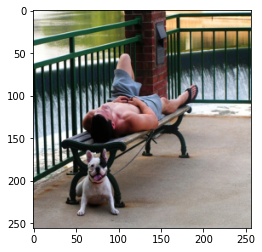

ایک سیاہ سفید کتا ایک گیند کے ساتھ کھیل رہا ہے


In [ ]:
#--------------------------------For manual analysis using Image vs. Prediction-------------------------------------
#data_folder = '/gdrive/My Drive/Colab Notebooks/ImageCaptionThesis/PyTorch'  # folder with data files saved by create_input_files.py
#data_name = 'DOGS_5_cap_per_img_2_min_word_freq'  # BASE NAME shared by data files
split='TEST'
h = h5py.File(os.path.join(data_folder, split + '_IMAGES_' + data_name + '.hdf5'), 'r')
imgs = h['images']


#word_map= '/gdrive/My Drive/Colab Notebooks/ImageCaptionThesis/PyTorch/WORDMAP_DOGS_5_cap_per_img_2_min_word_freq.json'
word_map =  data_folder+                                         '/WORDMAP_'+data_name+                     '.json'
# Load word map (word2ix)
with open(word_map, 'r') as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

import matplotlib.pyplot as plt
i=0
for i in range(len(imgs)):
  plt.imshow(imgs[i].transpose(1,2,0)) #Correct image dims from tensor CHW to image HWC
  plt.show()
  
  print(' '.join([ rev_word_map[wint] for wint in hypotheses[i] ]) )
  #bogusInput = input("Press any key to continue: ")
  plt.close()
  break;
#print(test_image_L[i])

In [ ]:
#VIsualize Attention with Word
#!pip install arabic_reshaper
#!pip install python-bidi
import arabic_reshaper
from bidi.algorithm import get_display
import torch
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform
import argparse
from scipy.misc import imread, imresize
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def caption_image_beam_search(encoder, decoder, image_path, word_map, beam_size=3):
    """
    Reads an image and captions it with beam search.
    :param encoder: encoder model
    :param decoder: decoder model
    :param image_path: path to image
    :param word_map: word map
    :param beam_size: number of sequences to consider at each decode-step
    :return: caption, weights for visualization
    """

    k = beam_size
    vocab_size = len(word_map)

    # Read image and process
    img = imread(image_path)
    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate([img, img, img], axis=2)
    img = imresize(img, (256, 256))
    img = img.transpose(2, 0, 1)
    img = img / 255.
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    image = transform(img)  # (3, 256, 256)

    # Encode
    image = image.unsqueeze(0)  # (1, 3, 256, 256)
    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

    # Tensor to store top k(i.e. beam_size) previous words at each step; now they're just <start>
    k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

    # Tensor to store top k(i.e. beam_size) sequences; now they're just <start>
    seqs = k_prev_words  # (k, 1)

    # Tensor to store top k(i.e. beam_size) sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

    # Tensor to store top k(i.e. beam_size) sequences' alphas; now they're just 1s
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    # Lists to store completed sequences, their alphas and scores
    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:

        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

        awe, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

        alpha = alpha.view(-1, enc_image_size, enc_image_size)  # (s, enc_image_size, enc_image_size)

        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
        awe = gate * awe

        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

        scores = decoder.fc(h)  # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)

        # Add
        scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words / vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        # Add new words to sequences, alphas
        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)],
                               dim=1)  # (s, step+1, enc_image_size, enc_image_size)

        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]

    return seq, alphas


def visualize_att(image_path, seq, alphas, rev_word_map, smooth=True):
    """
    Visualizes caption with weights at every word.
    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb
    :param image_path: path to image that has been captioned
    :param seq: caption
    :param alphas: weights
    :param rev_word_map: reverse word mapping, i.e. ix2word
    :param smooth: smooth weights?
    """
    image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)
    #image = image.resize([14 * 50, 14 * 50], Image.LANCZOS)

    words = [rev_word_map[ind] for ind in seq]
    
    plt.figure(figsize=(20, 8))
    for t in range(len(words)):
        if t > 50:
            break
        plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)

        plt.text(0, 1, '%s' % (get_display( arabic_reshaper.reshape(words[t]))), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image)
        current_alpha = alphas[t, :]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 24, 14 * 24])
            #alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 50, 14 * 50])
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show()


if __name__ == '__main__':
    '''
    parser = argparse.ArgumentParser(description='Show, Attend, and Tell - Tutorial - Generate Caption')

    parser.add_argument('--img', '-i', help='path to image')
    parser.add_argument('--model', '-m', help='path to model')
    parser.add_argument('--word_map', '-wm', help='path to word map JSON')
    parser.add_argument('--beam_size', '-b', default=5, type=int, help='beam size for beam search')
    parser.add_argument('--dont_smooth', dest='smooth', action='store_false', help='do not smooth alpha overlay')

    args = parser.parse_args()
    '''
    checkpoint= '/gdrive/My Drive/Colab Notebooks/ImageCaptionThesis/PyTorch/checkpoints/BEST_checkpoint_EncoderTunedFinalData_DOGS_5_cap_per_img_2_min_word_freq.pth.tar'#BEST_NoTransformLASERcheckpoint_FinalData_DOGS_5_cap_per_img_2_min_word_freq.pth.tar'
    #word_map_file= '/gdrive/My Drive/Colab Notebooks/ImageCaptionThesis/PyTorch/WORDMAP_DOGS_5_cap_per_img_2_min_word_freq.json'
    #checkpoint = data_folder+'/checkpoints/BEST_'+ModelType+'checkpoint_'+data_name+'.pth.tar'
    word_map_file =  data_folder+'/WORDMAP_'+data_name+                     '.json'
    beam_size=2
    smooth= False
    
    # Load model
    checkpoint = torch.load(checkpoint)
    decoder = checkpoint['decoder']
    decoder = decoder.to(device)
    decoder.eval()
    encoder = checkpoint['encoder']
    encoder = encoder.to(device)
    encoder.eval()

    # Load word map (word2ix)
    with open(word_map_file, 'r') as j:
        word_map = json.load(j)
    rev_word_map = {v: k for k, v in word_map.items()}  # ix2word
    for img in test_image_L:
      ##img='/gdrive/My Drive/dl/dogs/data/156967462_72db9b722c.jpg'
      # Encode, decode with attention and beam search
      seq, alphas = caption_image_beam_search(encoder, decoder, img, word_map, beam_size)
      alphas = torch.FloatTensor(alphas)

      # Visualize caption and attention of best sequence
      visualize_att(img, seq, alphas, rev_word_map, smooth)

ModuleNotFoundError: ignored